In [44]:
# Install required packages
!pip install boto3
!pip install pycuda

In [45]:
import os
import boto3


aws_access_key_id = ''
aws_secret_access_key = ''
aws_region = 'eu-west-1'
s3_bucket_name = 'myhpcbucket-160903'


# Initialize S3 client
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=aws_region
)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import yfinance as yf
import tensorflow as tf
import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import boto3

In [47]:
ticker = "GOOGL"  # Google stock symbol
start_date = "2004-01-01"
end_date = "2024-11-27"
df = yf.download(ticker, start=start_date, end=end_date)
df = df.reset_index()
df = df.drop(['Date', 'Adj Close'], axis=1)
df.shape

'''
ticker = "AAPL"  # Apple stock symbol
start_date = "2010-01-01"
end_date = "2024-01-01"
df = yf.download(ticker, start=start_date, end=end_date)
df = df.reset_index()
df = df.drop(['Date', 'Adj Close'], axis=1)
df.head()
'''

[*********************100%***********************]  1 of 1 completed
<ipython-input-47-80effd19c2f2>:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(['Date', 'Adj Close'], axis=1)


'\nticker = "AAPL"  # Apple stock symbol\nstart_date = "2010-01-01"\nend_date = "2024-01-01"\ndf = yf.download(ticker, start=start_date, end=end_date)\ndf = df.reset_index()\ndf = df.drop([\'Date\', \'Adj Close\'], axis=1)\ndf.head()\n'

In [48]:
df.shape

(5104, 5)

In [49]:
ma100 = df.Close.rolling(100).mean()

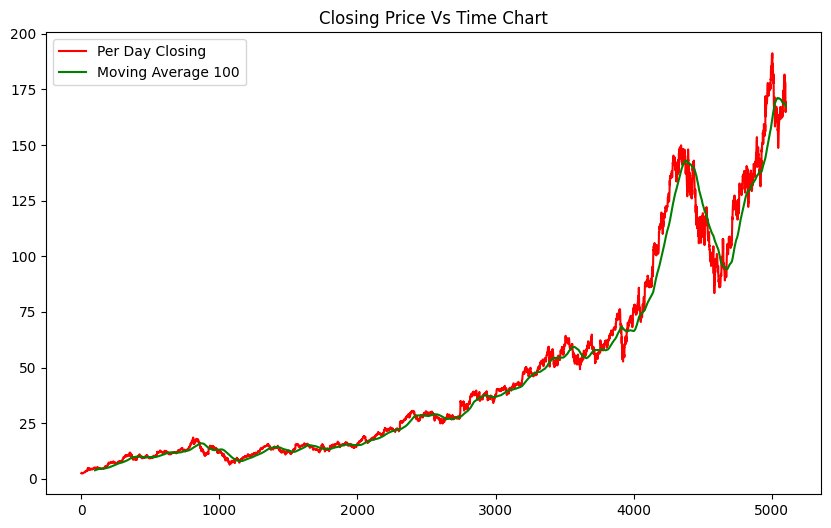

In [50]:
plt.figure(figsize = (10, 6))
plt.title("Closing Price Vs Time Chart")
plt.plot(df.Close, 'r', label="Per Day Closing")
plt.plot(ma100, 'g', label="Moving Average 100")
plt.legend()

In [51]:
ma200 = df.Close.rolling(200).mean()

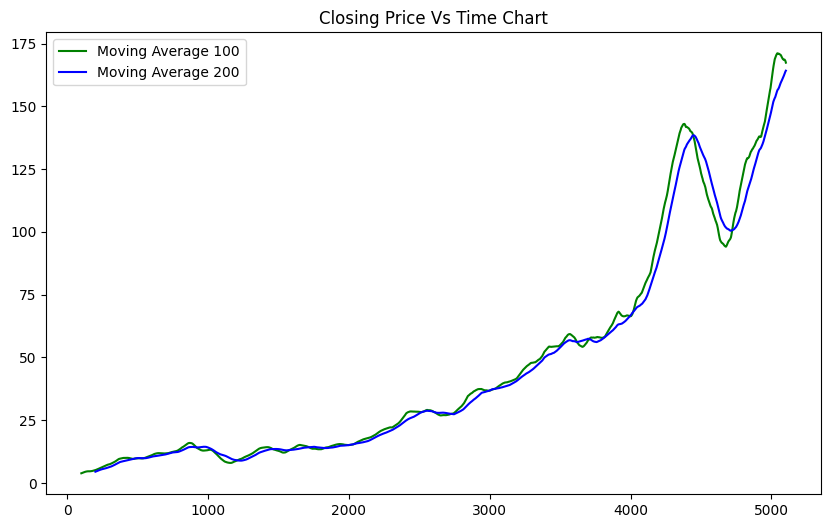

In [52]:
plt.figure(figsize = (10, 6))
plt.title("Closing Price Vs Time Chart")
plt.plot(ma100, 'g', label="Moving Average 100")
plt.plot(ma200, 'b', label="Moving Average 200")
plt.legend()

In [53]:
train_df = pd.DataFrame(df['Close'][0: int(len(df)*0.80)])
test_df = pd.DataFrame(df['Close'][int(len(df)*0.80):int(len(df))])
print(train_df.shape)
print(test_df.shape)

(4083, 1)
(1021, 1)


In [54]:
# Define the CUDA kernel
kernel_code = """
__global__ void min_max_scaler(float *data, float *min_vals, float *max_vals, int rows, int cols) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int col = idx % cols;
    int row = idx / cols;

    if (row < rows && col < cols) {
        float min_val = min_vals[col];
        float max_val = max_vals[col];
        data[idx] = (data[idx] - min_val) / (max_val - min_val);
    }
}
"""

mod = SourceModule(kernel_code)
min_max_scaler = mod.get_function("min_max_scaler")

# Get rows and cols
train_df1 = train_df.to_numpy().astype(np.float32)
rows, cols = train_df1.shape

# Calculate min and max values per column on the CPU
min_vals = train_df1.min(axis=0).astype(np.float32)
max_vals = train_df1.max(axis=0).astype(np.float32)

# Allocate GPU memory and transfer data
train_df_gpu = cuda.mem_alloc(train_df1.nbytes)
cuda.memcpy_htod(train_df_gpu, train_df1)
min_vals_gpu = cuda.mem_alloc(min_vals.nbytes)
cuda.memcpy_htod(min_vals_gpu, min_vals)
max_vals_gpu = cuda.mem_alloc(max_vals.nbytes)
cuda.memcpy_htod(max_vals_gpu, max_vals)

# Launch kernel
threads_per_block = 256
blocks_per_grid = (rows * cols + threads_per_block - 1) // threads_per_block
min_max_scaler(train_df_gpu, min_vals_gpu, max_vals_gpu, np.int32(rows), np.int32(cols),
               block=(threads_per_block, 1, 1), grid=(blocks_per_grid, 1))

# Copy back the scaled data
train_df_arr = np.empty_like(train_df1)
cuda.memcpy_dtoh(train_df_arr, train_df_gpu)

print("Scaled Data (NumPy Array):")
print(train_df_arr)

Scaled Data (NumPy Array):
[[9.7392265e-05]
 [2.4496703e-03]
 [2.7713832e-03]
 ...
 [9.2833447e-01]
 [9.4091851e-01]
 [1.0000000e+00]]


In [55]:
x_train = []
y_train = []
for i in range(100, train_df_arr.shape[0]):
    x_train.append(train_df_arr[i-100: i])
    y_train.append(train_df_arr[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((3983, 100, 1), (3983,))

In [56]:
# 1. Dropout is a regularization technique where randomly selected neurons are ignored during training.
# In order to prevent Neural Network from overfitting
# 2. LSTM, which stands for long short-term memory network, is a special kind of RNN that can perform
# learning from long-term dependencies, which is a problem when using simple RNN.
# 3. A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.
# 4. A dense layer is a fully connected layer used in the neural network's end stages
# to change the output's dimensionality from the preceding layer.
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [57]:
model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

# Zaid Stuff

In [59]:
# CUDA Kernel for Mean Squared Error Computation
cuda_mse_kernel = """
__global__ void compute_mse(float *predictions, float *true_values, float *mse, int n) {
    __shared__ float partial_sum[256];
    int tid = threadIdx.x;
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    float error = 0.0f;
    if (i < n) {
        error = predictions[i] - true_values[i];
        error = error * error;
    }

    // Parallel reduction in shared memory
    partial_sum[tid] = error;
    __syncthreads();

    for (int stride = blockDim.x/2; stride > 0; stride >>= 1) {
        if (tid < stride) {
            partial_sum[tid] += partial_sum[tid + stride];
        }
        __syncthreads();
    }

    // First thread writes the block's result
    if (tid == 0) {
        atomicAdd(mse, partial_sum[0] / n);
    }
}
"""

class PyCUDAMSEComputer:
    def __init__(self, block_size=256):
        """
        Initialize PyCUDA MSE Computer

        Args:
            block_size (int): CUDA block size for parallel computation
        """
        self.block_size = block_size

        # Compile CUDA kernel
        self.mod = SourceModule(cuda_mse_kernel)
        self.compute_mse_kernel = self.mod.get_function("compute_mse")

    def compute_mse_gpu(self, predictions, true_values):
        """
        Compute Mean Squared Error using GPU

        Args:
            predictions (np.ndarray): Model predictions
            true_values (np.ndarray): True target values

        Returns:
            float: Mean Squared Error
        """
        # Flatten predictions and true_values to 1D array
        predictions_flat = predictions.flatten().astype(np.float32)
        true_values_flat = true_values.flatten().astype(np.float32)

        # Check input compatibility
        assert predictions_flat.shape == true_values_flat.shape, "Flattened predictions and true values must have same shape"

        # Prepare GPU memory
        n = len(predictions_flat)
        grid_size = (n + self.block_size - 1) // self.block_size

        # Allocate GPU memory
        predictions_gpu = cuda.mem_alloc(predictions_flat.nbytes)
        true_values_gpu = cuda.mem_alloc(true_values_flat.nbytes)
        mse_gpu = cuda.mem_alloc(4)  # float size

        # Copy data to GPU
        cuda.memcpy_htod(predictions_gpu, predictions_flat)
        cuda.memcpy_htod(true_values_gpu, true_values_flat)

        # Initialize MSE to zero
        mse = np.zeros(1, dtype=np.float32)
        cuda.memcpy_htod(mse_gpu, mse)

        # Call CUDA kernel
        self.compute_mse_kernel(
            predictions_gpu, true_values_gpu, mse_gpu, np.int32(n),
            block=(self.block_size, 1, 1),
            grid=(grid_size, 1)
        )

        # Copy result back to host
        cuda.memcpy_dtoh(mse, mse_gpu)

        return mse[0]

In [60]:
def average_models(model, other_models):
        import numpy as np
        # Get weights from all models
        models = [model] + other_models
        weights = [m.get_weights() for m in models]
        new_weights = []
        for weights_list_tuple in zip(*weights):
            new_weights.append(
                np.array([np.array(w).astype(np.float32) for w in weights_list_tuple]).mean(axis=0)
            )
        # Set averaged weights to the model
        model.set_weights(new_weights)
        print("Model weights averaged.")
        return model

In [61]:
def save_model_to_s3(model, s3_client, bucket_name, model_key):
    """
    Save model to S3 with improved error handling

    Args:
        model (tf.keras.Model): Model to save
        s3_client (boto3.client): S3 client
        bucket_name (str): S3 bucket name
        model_key (str): S3 object key
    """
    try:
        # Save model in newer Keras format
        local_path = 'local_model.keras'
        model.save(local_path, save_format='keras')

        # Upload to S3 with explicit error handling
        try:
            s3_client.upload_file(local_path, bucket_name, model_key)
            print(f"Model saved to S3 bucket '{bucket_name}' with key '{model_key}'.")
        except Exception as upload_error:
            print(f"S3 Upload Error: {upload_error}")
            print("Credentials or permissions might be incorrect.")

            # Additional debugging information
            try:
                # Check bucket existence
                s3_client.head_bucket(Bucket=bucket_name)
                print(f"Bucket {bucket_name} exists.")
            except Exception as bucket_error:
                print(f"Bucket access error: {bucket_error}")

            # List buckets to verify credentials
            try:
                buckets = s3_client.list_buckets()
                print("Available buckets:")
                for bucket in buckets['Buckets']:
                    print(f"- {bucket['Name']}")
            except Exception as list_error:
                print(f"Error listing buckets: {list_error}")

    except Exception as save_error:
        print(f"Model save error: {save_error}")

def load_model_from_s3(s3_client, bucket_name, model_key):
    """
    Load model from S3 with improved error handling

    Args:
        s3_client (boto3.client): S3 client
        bucket_name (str): S3 bucket name
        model_key (str): S3 object key

    Returns:
        tf.keras.Model: Loaded model
    """
    try:
        local_path = 'downloaded_model.keras'

        # Download with explicit error handling
        try:
            s3_client.download_file(bucket_name, model_key, local_path)
        except Exception as download_error:
            print(f"S3 Download Error: {download_error}")
            print("Check if the object key is correct and you have read permissions.")
            raise

        # Load model
        model = tf.keras.models.load_model(local_path)
        print(f"Model loaded from S3 bucket '{bucket_name}' with key '{model_key}'.")
        return model

    except Exception as load_error:
        print(f"Model load error: {load_error}")
        raise

def verify_s3_credentials(s3_client):
    """
    Verify AWS S3 credentials and access

    Args:
        s3_client (boto3.client): S3 client

    Returns:
        bool: True if credentials are valid, False otherwise
    """
    try:
        # List buckets to verify credentials
        buckets = s3_client.list_buckets()
        print("S3 Credentials Verified. Available buckets:")
        for bucket in buckets['Buckets']:
            print(f"- {bucket['Name']}")
        return True
    except Exception as e:
        print(f"Credential Verification Failed: {e}")
        return False

class PyCUDASynchronizationCallback(tf.keras.callbacks.Callback):
    def __init__(self,
                 worker_id,
                 s3_client,
                 bucket_name,
                 sync_epochs=5,
                 mse_computer=None):
        """
        Initialize synchronization callback with S3 integration

        Args:
            worker_id (str): Unique identifier for the worker
            s3_client (boto3.client): S3 client
            bucket_name (str): S3 bucket name
            sync_epochs (int): Frequency of model synchronization
            mse_computer (PyCUDAMSEComputer): MSE computation object
        """
        super().__init__()
        self.worker_id = worker_id
        self.s3_client = s3_client
        self.bucket_name = bucket_name
        self.sync_epochs = sync_epochs
        self.mse_computer = mse_computer or PyCUDAMSEComputer()

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback method for epoch end with S3 synchronization

        Args:
            epoch (int): Current training epoch
            logs (dict): Logs from the training process
        """
        if (epoch + 1) % self.sync_epochs == 0:
            print(f"Epoch {epoch+1}: Synchronizing models.")

            # Compute GPU-accelerated MSE
            predictions = self.model.predict(x_train)
            gpu_mse = self.mse_computer.compute_mse_gpu(predictions, y_train)
            print(f"GPU-Accelerated MSE at epoch {epoch+1}: {gpu_mse}")

            # Save current model to S3
            model_key = f"model_checkpoints/{self.worker_id}_epoch_{epoch+1}.keras"
            save_model_to_s3(self.model, self.s3_client, self.bucket_name, model_key)

            # List and process other models
            try:
                response = self.s3_client.list_objects_v2(
                    Bucket=self.bucket_name,
                    Prefix='model_checkpoints/'
                )

                other_model_keys = [
                    obj['Key'] for obj in response.get('Contents', [])
                    if self.worker_id not in obj['Key'] and f"epoch_{epoch+1}" in obj['Key']
                ]

                other_models = []
                for other_model_key in other_model_keys:
                    other_model = load_model_from_s3(
                        self.s3_client,
                        self.bucket_name,
                        other_model_key
                    )
                    other_models.append(other_model)

                if other_models:
                    average_models(self.model, other_models)
                    print(f"Models synchronized at epoch {epoch+1}.")

                    averaged_model_key = f"model_checkpoints/averaged_epoch_{epoch+1}.keras"
                    save_model_to_s3(self.model, self.s3_client, self.bucket_name, averaged_model_key)
                else:
                    print("No other models found for synchronization.")

            except Exception as sync_error:
                print(f"Synchronization error: {sync_error}")


In [64]:
# Example Usage in Main Function
def main():
    # Verify S3 credentials before proceeding
    if not verify_s3_credentials(s3_client):
        print("Cannot proceed with training due to credential issues.")
        return

    # Initialize PyCUDA MSE Computer
    mse_computer = PyCUDAMSEComputer()

    # Assign worker ID
    worker_id = 'worker_0'

    # Create synchronization callback
    sync_callback = PyCUDASynchronizationCallback(
        worker_id,
        s3_client,
        s3_bucket_name,
        sync_epochs=5,
        mse_computer=mse_computer
    )

    # Compile and train model
    model.compile(loss='mean_squared_error', optimizer='adam')
    start_time = time.time()

    model.fit(
        x_train, y_train,
        epochs=100,
        batch_size=32,
        callbacks=[sync_callback]
    )

    end_time = time.time()

    elapsed_time = end_time - start_time

    print(f"Training completed in {elapsed_time:.2f} seconds.")

main()

S3 Credentials Verified. Available buckets:
- aws-cloudtrail-logs-657762149587-de790a22
- aws-cloudtrail-logs-657762149587-fc1656ec
- myhpcbucket-160903
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0051
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0039
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0031
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0034
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0030Epoch 5: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


GPU-Accelerated MSE at epoch 5: 0.0014366857940331101
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_5.keras'.
Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_5.keras'.
Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_50.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_55.keras'.
Model weights averaged.
Models synchronized at epoch 5.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_5.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.0030
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0128
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0024
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0021
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0018
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0021Epoch 10: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


GPU-Accelerated MSE at epoch 10: 0.0004446375241968781
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_10.keras'.
Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_10.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_100.keras'.
Model weights averaged.
Models synchronized at epoch 10.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_10.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 0.0021
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0089
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0026
Epoch 13/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0020
Epoch 14/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0022
Epoch 15/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0021Epoch 15: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


GPU-Accelerated MSE at epoch 15: 0.00047230496420525014
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_15.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_15.keras'.
Model weights averaged.
Models synchronized at epoch 15.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_15.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.0021
Epoch 16/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0030
Epoch 17/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0019
Epoch 18/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0019
Epoch 19/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0019
Epoch 20/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0016Epoch 20: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


GPU-Accelerated MSE at epoch 20: 0.0008592837839387357
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_20.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_20.keras'.
Model weights averaged.
Models synchronized at epoch 20.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_20.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.0016
Epoch 21/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.0021
Epoch 22/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0020
Epoch 23/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0017
Epoch 24/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0015
Epoch 25/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0016Epoch 25: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


GPU-Accelerated MSE at epoch 25: 0.0018807674059644341
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_25.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_25.keras'.
Model weights averaged.
Models synchronized at epoch 25.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_25.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.0016
Epoch 26/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0019
Epoch 27/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0016
Epoch 28/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0019
Epoch 29/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0018
Epoch 30/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0016Epoch 30: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


GPU-Accelerated MSE at epoch 30: 0.002055772114545107
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_30.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_30.keras'.
Model weights averaged.
Models synchronized at epoch 30.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_30.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - loss: 0.0016
Epoch 31/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0017
Epoch 32/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0016
Epoch 33/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0017
Epoch 34/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0015
Epoch 35/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0015Epoch 35: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


GPU-Accelerated MSE at epoch 35: 0.001873823581263423
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_35.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_35.keras'.
Model weights averaged.
Models synchronized at epoch 35.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_35.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.0015
Epoch 36/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0016
Epoch 37/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0015
Epoch 38/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0016
Epoch 39/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0016
Epoch 40/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0017Epoch 40: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


GPU-Accelerated MSE at epoch 40: 0.0031303148716688156
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_40.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_40.keras'.
Model weights averaged.
Models synchronized at epoch 40.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_40.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 0.0017
Epoch 41/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0014
Epoch 42/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0015
Epoch 43/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0016
Epoch 44/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0014
Epoch 45/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0014Epoch 45: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


GPU-Accelerated MSE at epoch 45: 0.0016279804985970259
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_45.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_45.keras'.
Model weights averaged.
Models synchronized at epoch 45.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_45.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.0014
Epoch 46/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.0014
Epoch 47/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0014
Epoch 48/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0014
Epoch 49/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0016
Epoch 50/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0015Epoch 50: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


GPU-Accelerated MSE at epoch 50: 0.002429676242172718
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_50.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_50.keras'.
Model weights averaged.
Models synchronized at epoch 50.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_50.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.0015
Epoch 51/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0016
Epoch 52/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0013
Epoch 53/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0014
Epoch 54/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0016
Epoch 55/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0015Epoch 55: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


GPU-Accelerated MSE at epoch 55: 0.0020109887700527906
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_55.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_55.keras'.
Model weights averaged.
Models synchronized at epoch 55.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_55.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 0.0015
Epoch 56/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.0088
Epoch 57/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0026
Epoch 58/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0022
Epoch 59/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0029
Epoch 60/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0018Epoch 60: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


GPU-Accelerated MSE at epoch 60: 0.0005847712745890021
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_60.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_60.keras'.
Model weights averaged.
Models synchronized at epoch 60.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_60.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.0018
Epoch 61/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.0034
Epoch 62/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0018
Epoch 63/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0017
Epoch 64/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0017
Epoch 65/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0016Epoch 65: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


GPU-Accelerated MSE at epoch 65: 0.0010012115817517042
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_65.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_65.keras'.
Model weights averaged.
Models synchronized at epoch 65.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_65.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.0016
Epoch 66/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0021
Epoch 67/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0017
Epoch 68/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0017
Epoch 69/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0015
Epoch 70/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0018Epoch 70: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


GPU-Accelerated MSE at epoch 70: 0.001035977154970169
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_70.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_70.keras'.
Model weights averaged.
Models synchronized at epoch 70.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_70.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.0018
Epoch 71/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.0018
Epoch 72/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0018
Epoch 73/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0015
Epoch 74/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0017
Epoch 75/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0015Epoch 75: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


GPU-Accelerated MSE at epoch 75: 0.001665077987127006
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_75.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_75.keras'.
Model weights averaged.
Models synchronized at epoch 75.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_75.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.0015
Epoch 76/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.0015
Epoch 77/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0016
Epoch 78/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0016
Epoch 79/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0015
Epoch 80/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0016Epoch 80: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


GPU-Accelerated MSE at epoch 80: 0.002048082649707794
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_80.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_80.keras'.
Model weights averaged.
Models synchronized at epoch 80.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_80.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.0016
Epoch 81/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.0017
Epoch 82/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0016
Epoch 83/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0015
Epoch 84/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0016
Epoch 85/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0014Epoch 85: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


GPU-Accelerated MSE at epoch 85: 0.003159173531457782
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_85.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_85.keras'.
Model weights averaged.
Models synchronized at epoch 85.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_85.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.0014
Epoch 86/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0017
Epoch 87/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0015
Epoch 88/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0014
Epoch 89/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0015
Epoch 90/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0015Epoch 90: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


GPU-Accelerated MSE at epoch 90: 0.002409408101812005
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_90.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_90.keras'.
Model weights averaged.
Models synchronized at epoch 90.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_90.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0015
Epoch 91/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0015
Epoch 92/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0015
Epoch 93/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0016
Epoch 94/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0015
Epoch 95/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0016Epoch 95: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


GPU-Accelerated MSE at epoch 95: 0.003176697064191103
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_95.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_95.keras'.
Model weights averaged.
Models synchronized at epoch 95.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_95.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 0.0016
Epoch 96/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0024
Epoch 97/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0017
Epoch 98/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0017
Epoch 99/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0013
Epoch 100/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0016Epoch 100: Synchronizing models.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


GPU-Accelerated MSE at epoch 100: 0.0026915224734693766
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_100.keras'.


Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_5_epoch_100.keras'.
Model weights averaged.
Models synchronized at epoch 100.
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/averaged_epoch_100.keras'.
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 0.0016
Training completed in 999.59 seconds.


In [ ]:
model.save('keras_model.h5')

In [65]:
past_100_days = train_df.tail(100)
final_df = past_100_days._append(test_df, ignore_index=True)
final_df.head()

Ticker,GOOGL
0,72.323502
1,72.626999
2,71.706001
3,71.232002
4,72.532997


In [66]:
# Define the CUDA kernel
kernel_code = """
__global__ void min_max_scaler(float *data, float *min_vals, float *max_vals, int rows, int cols) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int col = idx % cols;
    int row = idx / cols;

    if (row < rows && col < cols) {
        float min_val = min_vals[col];
        float max_val = max_vals[col];
        data[idx] = (data[idx] - min_val) / (max_val - min_val);
    }
}
"""

# Compile the kernel
mod = SourceModule(kernel_code)
min_max_scaler = mod.get_function("min_max_scaler")

# Assuming final_df is a Pandas DataFrame
final_df_arr = final_df.to_numpy().astype(np.float32)  # Convert to NumPy array
rows, cols = final_df_arr.shape

# Calculate min and max values per column for final_df
min_vals_final = final_df_arr.min(axis=0).astype(np.float32)
max_vals_final = final_df_arr.max(axis=0).astype(np.float32)

# Allocate GPU memory and transfer data
final_df_gpu = cuda.mem_alloc(final_df_arr.nbytes)
cuda.memcpy_htod(final_df_gpu, final_df_arr)

min_vals_final_gpu = cuda.mem_alloc(min_vals_final.nbytes)
cuda.memcpy_htod(min_vals_final_gpu, min_vals_final)

max_vals_final_gpu = cuda.mem_alloc(max_vals_final.nbytes)
cuda.memcpy_htod(max_vals_final_gpu, max_vals_final)

# Launch the CUDA kernel
threads_per_block = 256
blocks_per_grid = (rows * cols + threads_per_block - 1) // threads_per_block
min_max_scaler(final_df_gpu, min_vals_final_gpu, max_vals_final_gpu, np.int32(rows), np.int32(cols),
               block=(threads_per_block, 1, 1), grid=(blocks_per_grid, 1))

# Copy back the scaled data
final_df_scaled = np.empty_like(final_df_arr)
cuda.memcpy_dtoh(final_df_scaled, final_df_gpu)

# `final_df_scaled` is now a scaled NumPy array
input_data = final_df_scaled  # Keep as NumPy array

# Display the first few rows of the scaled array
print("Scaled data (array):")
print(input_data[:5])  # Print the first 5 rows
print("Input data shape:", input_data.shape)


Scaled data (array):
[[0.03410321]
 [0.03656961]
 [0.02908505]
 [0.02523306]
 [0.0358057 ]]
Input data shape: (1121, 1)


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


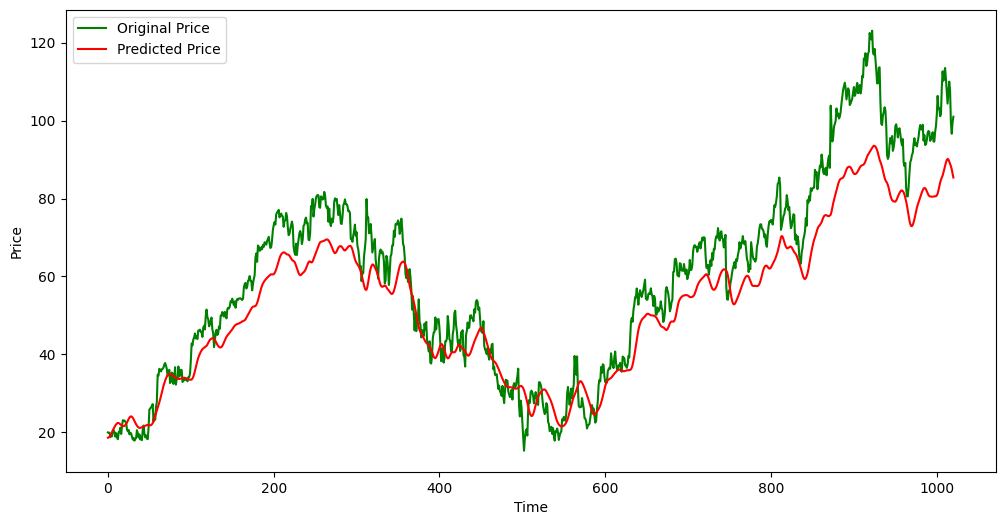

In [67]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape
y_pred = model.predict(x_test)

final_df_arr = final_df.to_numpy().astype(np.float32)
rows, cols = final_df_arr.shape

# Calculate min and max values per column for final_df
min_vals_final = final_df_arr.min(axis=0).astype(np.float32)
max_vals_final = final_df_arr.max(axis=0).astype(np.float32)

# Calculate the scale values for each feature
scale = 1.0 / (max_vals_final - min_vals_final)
scale_factor = 1/scale
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor


plt.figure(figsize=(12, 6))
plt.plot(y_test, 'g', label="Original Price")
plt.plot(y_pred, 'r', label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()